**Řešíme 2D úlohu konekce:**
$$\begin{align*}
    \frac{\partial u}{\partial t} + \beta \frac{\partial u}{\partial x} &= 0, \quad x \in [0, 2\pi],\,t\in[0, 1] \\
    u(x, 0) &= \sin(x) + \cos(x) \\
    u(0, t) &= u(2\pi, t),
\end{align*}$$
kde $\beta > 0$ je koeficient konvekce. Analytické řešení je
$$\begin{equation*}
    u(x, t) = \sin(x - \beta t) + \cos(x - \beta t).
\end{equation*}$$
Níže natrénujeme model řešící tuto úlohu, a poté jej porovnáme se správným řešením úlohy.
První trénování proběhne bez použití fourier features, druhé s jejich použitím.

In [68]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
# Zakladni importy
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import sys

In [70]:
# Import vlastnich modulu
sys.path.append("..")
import src.data.cube_domain as cb
import src.models.mlp_model as mm
from src import train
from src import calculus as calc
from src import utils

In [71]:
# Volba spravneho device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [72]:
# Definice ztratove funkce

BETA = 30 # BETA -- konstanta konvekce

# BETA neni argument funkce, protoze kazdy trenovaci algoritmus ocekava, ze 
# jako argument jen a pouze model a domena.
def loss_fn(model: torch.nn.Module, domain: cb.CubeDomain) -> torch.Tensor:
    _, u_x, u_t = calc.compute_derivatives_2d(model, domain.interior)
    pde_loss = torch.mean((u_t + BETA * u_x)**2)

    u_bottom = model(domain.sides[1][0])
    left_loss = torch.mean((u_bottom - torch.sin(domain.sides[1][0][:, 0:1]) 
                            - torch.cos(domain.sides[1][0][:, 0:1]))**2)

    u_left = model(domain.sides[0][0])
    u_right = model(domain.sides[0][1])
    top_bot_loss = torch.mean((u_left - u_right)**2)

    return [pde_loss, left_loss, top_bot_loss]

def exact_solution(x: torch.Tensor) -> torch.Tensor:
    return torch.sin(x[:, 0:1] - BETA * x[:, 1:2]) + torch.cos(x[:, 0:1] - BETA * x[:, 1:2])

def l2_loss(model: torch.nn.Module, domain: cb.CubeDomain) -> torch.Tensor:
    return calc.l2_dist_2d(model, exact_solution, domain.ctx.u_bounds, domain.ctx.l_bounds, device)

In [73]:
# Definice modelu, domeny problemu a optimalizatoru
# prostor x je prvni (nulta) promenna,
# cas t je druha (prvni) promenna
domain_ctx = cb.CubeContext(
    dim=2,
    l_bounds=[0, 0],
    u_bounds=[2*np.pi, 1],
    N_int=10_000,
    N_sides=[(500, 500), (500, 500)],
    device=device,
    mirror_left_right=[True, False]
)

model_ctx = mm.ModelContext(
    input_dim=2,
    output_dim=1,
    layer=[64, 64, 128],
    u_bounds=domain_ctx.u_bounds,
    l_bounds=domain_ctx.l_bounds,
    fourier_features=False
)

model = mm.MLPModel(model_ctx).to(device)
domain = cb.CubeDomain(domain_ctx)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scheduler = ReduceLROnPlateau(optimizer=optimizer, factor=0.5, patience=300)

In [74]:
# Trenujeme algoritmus a ukladame hodnoty ztraty
train_ctx = train.TrainingContext(
    model=model,
    optimizer=optimizer,
    domain=domain,
    loss_fn=loss_fn,
    epochs=10_000,
    monitor_lr=True,
    scheduler=scheduler,
    resample_freq=100
)


total_loss_values, component_loss_values = train.train_switch_to_lbfgs(train_ctx, epochs_with_lbfgs=1000, lbfgs_lr=0.08)

Loss at epoch 1 is: 1.4716565608978271. Current learing rate: 0.0005 
Loss at epoch 100 is: 1.0084420442581177. Current learing rate: 0.0005 
Loss at epoch 200 is: 0.9030143022537231. Current learing rate: 0.0005 
Loss at epoch 300 is: 0.8907601833343506. Current learing rate: 0.0005 
Loss at epoch 400 is: 0.7806463241577148. Current learing rate: 0.0005 
Loss at epoch 500 is: 0.2788204550743103. Current learing rate: 0.0005 
Loss at epoch 600 is: 0.1567063331604004. Current learing rate: 0.0005 
Loss at epoch 700 is: 0.14337292313575745. Current learing rate: 0.0005 
Loss at epoch 800 is: 0.13480882346630096. Current learing rate: 0.0005 
Loss at epoch 900 is: 0.1188940703868866. Current learing rate: 0.0005 
Loss at epoch 1000 is: 0.11184161901473999. Current learing rate: 0.0005 
Loss at epoch 1100 is: 0.10249686986207962. Current learing rate: 0.0005 
Loss at epoch 1200 is: 0.09362226724624634. Current learing rate: 0.0005 
Loss at epoch 1300 is: 0.09021301567554474. Current learin

In [77]:
# A nyni s fourier features
model_ctx.fourier_features = 'Timeless'
model_ctx.fourier_frequencies = 256
model_ctx.fourier_scale = 2.0 # arbitrarni hodnoty

model_ff = mm.MLPModel(model_ctx).to(device)
optimizer_ff = torch.optim.Adam(model_ff.parameters(), lr=0.0001)
scheduler_ff = ReduceLROnPlateau(optimizer=optimizer_ff, factor=0.75, patience=200)

In [ ]:
# Trenujeme algoritmus a ukladame hodnoty ztraty
train_ctx.model = model_ff
train_ctx.optimizer = optimizer_ff
train_ctx.scheduler = None
train_ctx.epochs = 10_000

total_loss_values_ff, component_loss_values_ff = train.train_switch_to_lbfgs(train_ctx, epochs_with_lbfgs=500, lbfgs_lr=0.1)

Loss at epoch 1 is: 24.248939514160156. Current learing rate: 0.0001 
Loss at epoch 100 is: 1.0436081886291504. Current learing rate: 0.0001 
Loss at epoch 200 is: 1.0001826286315918. Current learing rate: 0.0001 
Loss at epoch 300 is: 0.9957252144813538. Current learing rate: 0.0001 
Loss at epoch 400 is: 0.9911553263664246. Current learing rate: 0.0001 
Loss at epoch 500 is: 0.9211357831954956. Current learing rate: 0.0001 
Loss at epoch 600 is: 0.8558862209320068. Current learing rate: 0.0001 
Loss at epoch 700 is: 0.8958902955055237. Current learing rate: 0.0001 
Loss at epoch 800 is: 0.8536745309829712. Current learing rate: 0.0001 
Loss at epoch 900 is: 0.6882655620574951. Current learing rate: 0.0001 
Loss at epoch 1000 is: 0.48148784041404724. Current learing rate: 0.0001 
Loss at epoch 1100 is: 0.2831021249294281. Current learing rate: 0.0001 
Loss at epoch 1200 is: 0.18663260340690613. Current learing rate: 0.0001 
Loss at epoch 1300 is: 0.14679640531539917. Current learing r

In [ ]:
# Vykresleni ztraty
plot_ctx = utils.PlotContext(
    l_bounds = [0, 0],
    u_bounds=[2*np.pi, 1],
    patches=[],
    device=device,
    vmin=-1.3,
    vmax=1.3,
    N=100,
    save_img=False,
    x_label='Epochs',
    y_label='Loss',
)

plot_ctx.title = 'Total loss comparison'
utils.plot_loss_values({"Loss without ff": total_loss_values, "Loss using ff": total_loss_values_ff}, plot_ctx)
plot_ctx.title = 'Component wise loss without Fourier features (no lbfgs)'
utils.plot_loss_values({"PDE loss": component_loss_values[0],
                        "Left loss": component_loss_values[1],
                        "Top-Bot loss": component_loss_values[2]}, plot_ctx)

NameError: name 'total_loss_values' is not defined

/home/berva/Projects/PINNs/Introduction/notebooks/../src/utils.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels)


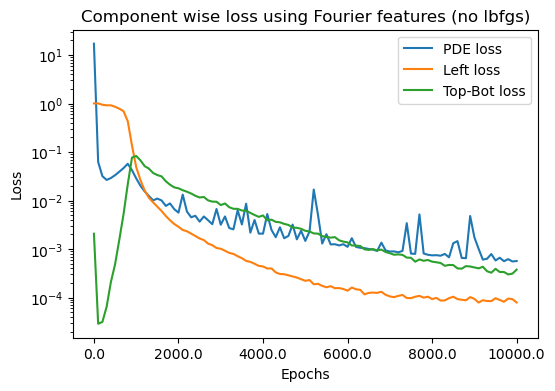

In [ ]:
plot_ctx.title = 'Total loss using Fourier features'
plot_ctx.title = 'Component wise loss using Fourier features (no lbfgs)'
utils.plot_loss_values({"PDE loss": component_loss_values_ff[0],
                        "Left loss": component_loss_values_ff[1],
                        "Top-Bot loss": component_loss_values_ff[2]}, plot_ctx)

/home/berva/anaconda3/envs/pytorch/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647329220/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


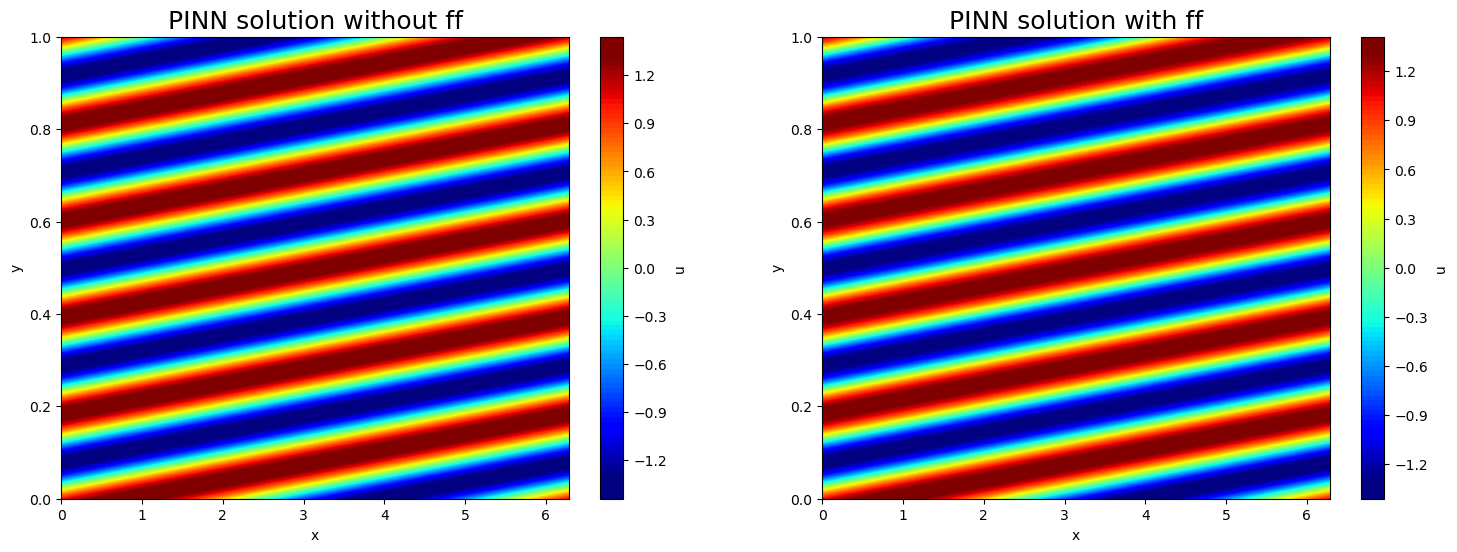

In [ ]:
# Vykresleni priblizneho reseni (minus interpolace)
plot_ctx.titles = ['PINN solution without ff', 'PINN solution with ff']
plot_ctx.x_label = 'x'
plot_ctx.y_label = 'y'
plot_ctx.function_names = ['u', 'u']
plot_ctx.figsize = (18, 6)
plot_ctx.fontsize = 18

utils.plot_function_on_2d_cube([model, model_ff], plot_ctx)

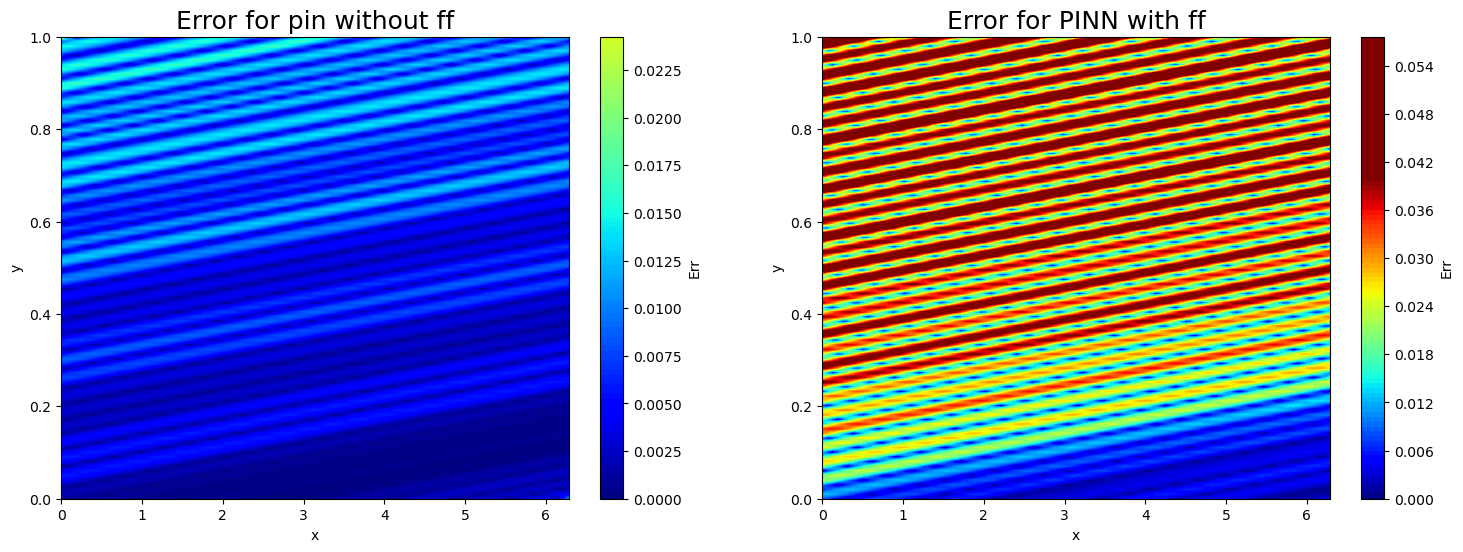

In [ ]:
plot_ctx.titles = ['Error for pin without ff', 'Error for PINN with ff']
plot_ctx.function_names = ['Err', 'Err']
plot_ctx.figsize = (18, 6)
plot_ctx.fontsize = 18
plot_ctx.vmax=0.04
plot_ctx.vmin=0.0

utils.plot_function_on_2d_cube([lambda x: torch.abs(model(x) - exact_solution(x)),
                                lambda x: torch.abs(model_ff(x) - exact_solution(x))], plot_ctx)

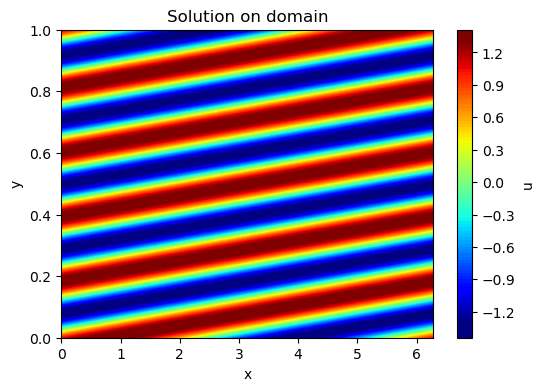

In [ ]:
torch.cuda.empty_cache()


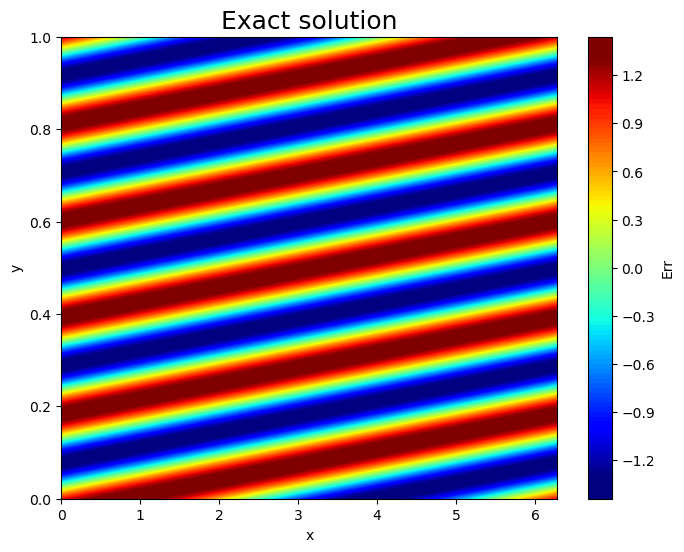

In [ ]:
# Vykresleni skutecneho reseni (minus interpolace)
BETA = 30
plot_ctx.titles = ['Exact solution']
plot_ctx.vmin=-1.3
plot_ctx.vmax=1.3
plot_ctx.figsize = (8, 6)

utils.plot_function_on_2d_cube([exact_solution], plot_ctx)

In [ ]:
# a na zaver porovnani pomoci L2 normy
norm = calc.L2_norm(model, exact_solution, 2, domain_ctx.u_bounds, domain_ctx.l_bounds, device)

print(f"L2 chyba bez ff je {norm}")

norm_ff = calc.L2_norm(model_ff, exact_solution, 2, domain_ctx.u_bounds, domain_ctx.l_bounds, device, n=100)

print(f"L2 chyba s ff je {norm_ff}")

L2 chyba bez ff je 0.016222435981035233
L2 chyba s ff je 0.07223282754421234
